### Part 1 Import packages

In [138]:
# import required packages
import geopandas as gpd
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale

import statsmodels.api as sm

In [139]:
# colab users only - uncomment to run
!pip install mapclassify

# Part 2 Data Cleaning and Preparation

#### 2.1 Read in the ward shapefile for London

In [140]:
London_Ward = gpd.read_file("London_Ward_CityMerged.shp")

In [141]:
# Explore the data
London_Ward.info()
London_Ward.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        633 non-null    object  
 1   GSS_CODE    633 non-null    object  
 2   DISTRICT    633 non-null    object  
 3   LAGSSCODE   633 non-null    object  
 4   HECTARES    633 non-null    float64 
 5   NONLD_AREA  633 non-null    float64 
 6   geometry    633 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 34.7+ KB


,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16..."


In [142]:
London_Ward = London_Ward.to_crs(epsg = 27700)

In [144]:
London_Ward.explore()

Output hidden; open in https://colab.research.google.com to view.

#### 2.2 Read in the Airbnb data in London

In [145]:
Airbnb = pd.read_csv("/content/Aribnb.csv")

In [146]:
Airbnb.head()

,id,name,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,...,last_scraped,source,latitude,longitude,price,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,312761,Spacious Central London Apartment by Hoxton Sq...,2012-07-12,2024-02-03,4.96,4.97,4.93,4.96,5.00,4.89,...,2024-03-21,city scrape,51.52704,-0.08129,$160.00,1,1,0,0,0.86
1,13913,Holiday London DB Room Let-on going,2010-08-18,2023-11-26,4.80,4.73,4.73,4.75,4.83,4.70,...,2024-03-20,city scrape,51.56861,-0.11270,$65.00,3,2,1,0,0.25
2,15400,Bright Chelsea Apartment. Chelsea!,2009-12-21,2023-05-01,4.80,4.85,4.88,4.88,4.83,4.93,...,2024-03-20,city scrape,51.48780,-0.16813,$120.00,1,1,0,0,0.54
3,159736,A double Room 5mins from King's College Hospital,2011-07-16,2023-04-29,4.72,4.79,4.66,4.75,4.89,4.34,...,2024-03-20,city scrape,51.46788,-0.09993,$65.00,4,0,4,0,0.62
4,165336,Charming Flat in Notting Hill,2011-10-16,2024-03-17,4.74,4.88,4.79,4.94,4.96,4.87,...,2024-03-21,city scrape,51.51735,-0.21076,$100.00,1,1,0,0,1.57


In [147]:
# explore data types
Airbnb.info()
Airbnb.isna().drop
Airbnb.describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90852 entries, 0 to 90851
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            90852 non-null  int64  
 1   name                                          90852 non-null  object 
 2   first_review                                  65869 non-null  object 
 3   last_review                                   65869 non-null  object 
 4   review_scores_rating                          65869 non-null  float64
 5   review_scores_accuracy                        65838 non-null  float64
 6   review_scores_cleanliness                     65843 non-null  float64
 7   review_scores_checkin                         65808 non-null  float64
 8   review_scores_communication                   65833 non-null  float64
 9   review_scores_location                        65808 non-null 

<bound method NDFrame.describe of                         id                                               name  \
0                   312761  Spacious Central London Apartment by Hoxton Sq...   
1                    13913                Holiday London DB Room Let-on going   
2                    15400                Bright Chelsea  Apartment. Chelsea!   
3                   159736   A double Room 5mins from King's College Hospital   
4                   165336                      Charming Flat in Notting Hill   
...                    ...                                                ...   
90847  1115272743905612628                           Primrose Hill Studio #25   
90848  1115272767893608505                           Primrose Hill Studio #27   
90849  1115285644506865913                Quad Bedroom with External Bathroom   
90850  1115338006572763275                               Grosvenor Collection   
90851  1115347885713265376                            Comfy Home - Wood Green   

      first_review last_review  review_scores_rating  review_scores_accuracy  \
0       2012-07-12  2024-02-03                  4.96                    4.97   
1       2010-08-18  2023-11-26                  4.80                    4.73   
2       2009-12-21  2023-05-01                  4.80                    4.85   
3       2011-07-16  2023-04-29                  4.72                    4.79   
4       2011-10-16  2024-03-17                  4.74                    4.88   
...            ...         ...                   ...                     ...   
90847          NaN         NaN                   NaN                     NaN   
90848          NaN         NaN                   NaN                     NaN   
90849          NaN         NaN                   NaN                     NaN   
90850          NaN         NaN                   NaN                     NaN   
90851          NaN         NaN                   NaN                     NaN   

       review_scores_cleanliness  review_scores_checkin  \
0                           4.93                   4.96   
1                           4.73                   4.75   
2                           4.88                   4.88   
3                           4.66                   4.75   
4                           4.79                   4.94   
...                          ...                    ...   
90847                        NaN                    NaN   
90848                        NaN                    NaN   
90849                        NaN                    NaN   
90850                        NaN                    NaN   
90851                        NaN                    NaN   

       review_scores_communication  review_scores_location  ...  last_scraped  \
0                             5.00                    4.89  ...    2024-03-21   
1                             4.83                    4.70  ...    2024-03-20   
2                             4.83                    4.93  ...    2024-03-20   
3                             4.89                    4.34  ...    2024-03-20   
4                             4.96                    4.87  ...    2024-03-21   
...                            ...                     ...  ...           ...   
90847                          NaN                     NaN  ...    2024-03-19   
90848                          NaN                     NaN  ...    2024-03-19   
90849                          NaN                     NaN  ...    2024-03-21   
90850                          NaN                     NaN  ...    2024-03-20   
90851                          NaN                     NaN  ...    2024-03-19   

            source   latitude longitude    price  \
0      city scrape  51.527040 -0.081290  $160.00   
1      city scrape  51.568610 -0.112700   $65.00   
2      city scrape  51.487800 -0.168130  $120.00   
3      city scrape  51.467880 -0.099930   $65.00   
4      city scrape  51.517350 -0.210760  $100.00   
...            ...        ...       ..

In [148]:
# Remove "$" and "," from the price column
Airbnb['price'] = Airbnb['price'].replace({'\$': '', ',': ''}, regex=True)

# Convert the price column to numeric (float)
Airbnb['price'] = pd.to_numeric(Airbnb['price'])

In [149]:
# Create point geometries using the Airbnb data
Airbnb_geoms = gpd.points_from_xy(x=Airbnb.longitude, y= Airbnb.latitude, crs="EPSG:4326")

# Convert the Airbnb data to a GeoDataFrame and add the geometry column
Airbnb_gdf = gpd.GeoDataFrame(Airbnb, geometry = Airbnb_geoms)

# Convert the CRS of the Airbnb
Airbnb_gdf = Airbnb_gdf.to_crs(epsg = 27700)

#### 2.3 Join the Airbnb data to the London wards

In [150]:
# Perform spatial join to match Airbnb points to London wards
London_Airbnb = gpd.sjoin(Airbnb_gdf, London_Ward, how="inner", predicate="within")

In [151]:
London_Airbnb.head()

,id,name,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,...,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA
0,312761,Spacious Central London Apartment by Hoxton Sq...,2012-07-12,2024-02-03,4.96,4.97,4.93,4.96,5.00,4.89,...,0,0.86,POINT (533199.044 182647.709),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
75,227502,Shoreditch Loft,2011-10-06,2021-11-01,4.42,4.67,4.68,4.70,4.69,4.69,...,0,0.90,POINT (533472.843 182820.703),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
128,244125,Artist City Retreats x 2 - with amazing views!,2013-02-27,2023-09-10,4.57,4.67,4.47,4.77,4.84,4.45,...,0,2.36,POINT (533216.671 182901.888),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
130,244126,"Artist's Retreat with Panoramic Views, Hoxton",2011-10-27,2024-01-01,4.64,4.60,4.48,4.82,4.90,4.66,...,0,1.17,POINT (533080.153 183264.419),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
202,359974,Charming 2-bed Shoreditch Apartment,2012-08-27,2024-01-01,4.66,4.77,4.65,4.94,4.94,4.90,...,0,0.77,POINT (533098.447 182725.193),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0


#### 2.4 London_Airbnb data exploration and preprocessing

In [152]:
London_Airbnb.head()

,id,name,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,...,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA
0,312761,Spacious Central London Apartment by Hoxton Sq...,2012-07-12,2024-02-03,4.96,4.97,4.93,4.96,5.00,4.89,...,0,0.86,POINT (533199.044 182647.709),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
75,227502,Shoreditch Loft,2011-10-06,2021-11-01,4.42,4.67,4.68,4.70,4.69,4.69,...,0,0.90,POINT (533472.843 182820.703),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
128,244125,Artist City Retreats x 2 - with amazing views!,2013-02-27,2023-09-10,4.57,4.67,4.47,4.77,4.84,4.45,...,0,2.36,POINT (533216.671 182901.888),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
130,244126,"Artist's Retreat with Panoramic Views, Hoxton",2011-10-27,2024-01-01,4.64,4.60,4.48,4.82,4.90,4.66,...,0,1.17,POINT (533080.153 183264.419),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0
202,359974,Charming 2-bed Shoreditch Apartment,2012-08-27,2024-01-01,4.66,4.77,4.65,4.94,4.94,4.90,...,0,0.77,POINT (533098.447 182725.193),555,Hoxton East & Shoreditch,E05009377,Hackney,E09000012,102.355,0.0


In [153]:
# View Missing Values
London_Airbnb.info
London_Airbnb.isna().drop

<bound method DataFrame.drop of           id   name  first_review  last_review  review_scores_rating  \
0      False  False         False        False                 False   
75     False  False         False        False                 False   
128    False  False         False        False                 False   
130    False  False         False        False                 False   
202    False  False         False        False                 False   
...      ...    ...           ...          ...                   ...   
53787  False  False         False        False                 False   
53788  False  False         False        False                 False   
63969  False  False         False        False                 False   
65274  False  False          True         True                  True   
74123  False  False         False        False                 False   

       review_scores_accuracy  review_scores_cleanliness  \
0                       False                      False   
75                      False                      False   
128                     False                      False   
130                     False                      False   
202                     False                      False   
...                       ...                        ...   
53787                   False                      False   
53788                   False                      False   
63969                   False                      False   
65274                    True                       True   
74123                   False                      False   

       review_scores_checkin  review_scores_communication  \
0                      False                        False   
75                     False                        False   
128                    False                        False   
130                    False                        False   
202                    False                        False   
...                      ...                          ...   
53787                  False                        False   
53788                  False                        False   
63969                  False                        False   
65274                   True                         True   
74123                  False                        False   

       review_scores_location  ...  \
0                       False  ...   
75                      False  ...   
128                     False  ...   
130                     False  ...   
202                     False  ...   
...                       ...  ...   
53787                   False  ...   
53788                   False  ...   
63969                   False  ...   
65274                    True  ...   
74123                   False  ...   

       calculated_host_listings_count_shared_rooms  reviews_per_month  \
0                                            False              False   
75                                           False              False   
128                                          False              False   
130                                          False              False   
202                                          False              False   
...                                            ...                ...   
53787                                        False              False   
53788                                        False              False   
63969                                        False              False   
65274                                        False               True   
74123                                        False              False   

       geometry  index_right   NAME  GSS_CODE  DISTRICT  LAGSSCODE  HECTARES  \
0         False        False  False     False     False      False     False   
75        False        False  False     False     False      False     False   
128       False        False  False     False     False      False     Fals

In [154]:
# Calculate 8 average scores for each wards
Rating = London_Airbnb.groupby('GSS_CODE')['review_scores_rating'].mean().reset_index()
Accuracy = London_Airbnb.groupby('GSS_CODE')['review_scores_accuracy'].mean().reset_index()
Cleanliness  = London_Airbnb.groupby('GSS_CODE')['review_scores_cleanliness'].mean().reset_index()
Checkin = London_Airbnb.groupby('GSS_CODE')['review_scores_checkin'].mean().reset_index()
Communication = London_Airbnb.groupby('GSS_CODE')['review_scores_communication'].mean().reset_index()
Location = London_Airbnb.groupby('GSS_CODE')['review_scores_location'].mean().reset_index()
Value = London_Airbnb.groupby('GSS_CODE')['review_scores_value'].mean().reset_index()
Price = London_Airbnb.groupby('GSS_CODE')['price'].mean().reset_index()

In [155]:
# Merge average price data with London wards
merge1= London_Ward.merge(Rating, on='GSS_CODE', how='left')
merge2= merge1.merge(Accuracy, on='GSS_CODE', how='left')
merge3= merge2.merge(Cleanliness, on='GSS_CODE', how='left')
merge4= merge3.merge(Checkin, on='GSS_CODE', how='left')
merge5= merge4.merge(Communication, on='GSS_CODE', how='left')
merge6= merge5.merge(Location, on='GSS_CODE',how='left')
merge7= merge6.merge(Value, on='GSS_CODE',how='left')
London_Airbnb = merge7.merge(Price, on='GSS_CODE',how='left')

In [156]:
# Rename columns
rename_column = {"review_scores_rating": "Rating", "review_scores_accuracy":"Accuracy","review_scores_cleanliness":"Cleanliness","review_scores_checkin":"Checkin","review_scores_communication":"Communication","review_scores_location":"Location","review_scores_value":"Value"}  # Specify column rename mapping
London_Airbnb = London_Airbnb.rename(columns=rename_column)

In [157]:
# Drop same columns
drop_columns = ["LAGSSCODE", "NONLD_AREA"]
London_Airbnb = London_Airbnb.drop(columns = drop_columns)

In [158]:
London_Airbnb.head()

,NAME,GSS_CODE,DISTRICT,HECTARES,geometry,Rating,Accuracy,Cleanliness,Checkin,Communication,Location,Value,price
0,Chessington South,E05000405,Kingston upon Thames,755.173,"POLYGON ((516401.596 160201.802, 516407.302 16...",4.790000,4.759286,4.682857,4.785714,4.911429,4.695714,4.712143,129.470588
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,259.464,"POLYGON ((519552.998 164295.600, 519508.096 16...",4.852727,4.859091,4.770909,4.920000,4.937273,4.646364,4.760000,111.538462
2,Berrylands,E05000401,Kingston upon Thames,145.390,"POLYGON ((518107.499 167303.399, 518114.301 16...",4.875758,4.896364,4.856364,4.946061,4.923636,4.822727,4.789394,128.192308
3,Alexandra,E05000400,Kingston upon Thames,268.506,"POLYGON ((520336.700 165105.498, 520332.198 16...",4.749412,4.789412,4.791176,4.818235,4.827059,4.637647,4.567647,160.200000
4,Beverley,E05000402,Kingston upon Thames,187.821,"POLYGON ((521201.203 169275.505, 521204.303 16...",4.842857,4.920714,4.877143,4.985000,4.913571,4.808214,4.774643,96.000000


# Part 3 Exploring the different review domains in London

##### 3.1 7 review domains map in London

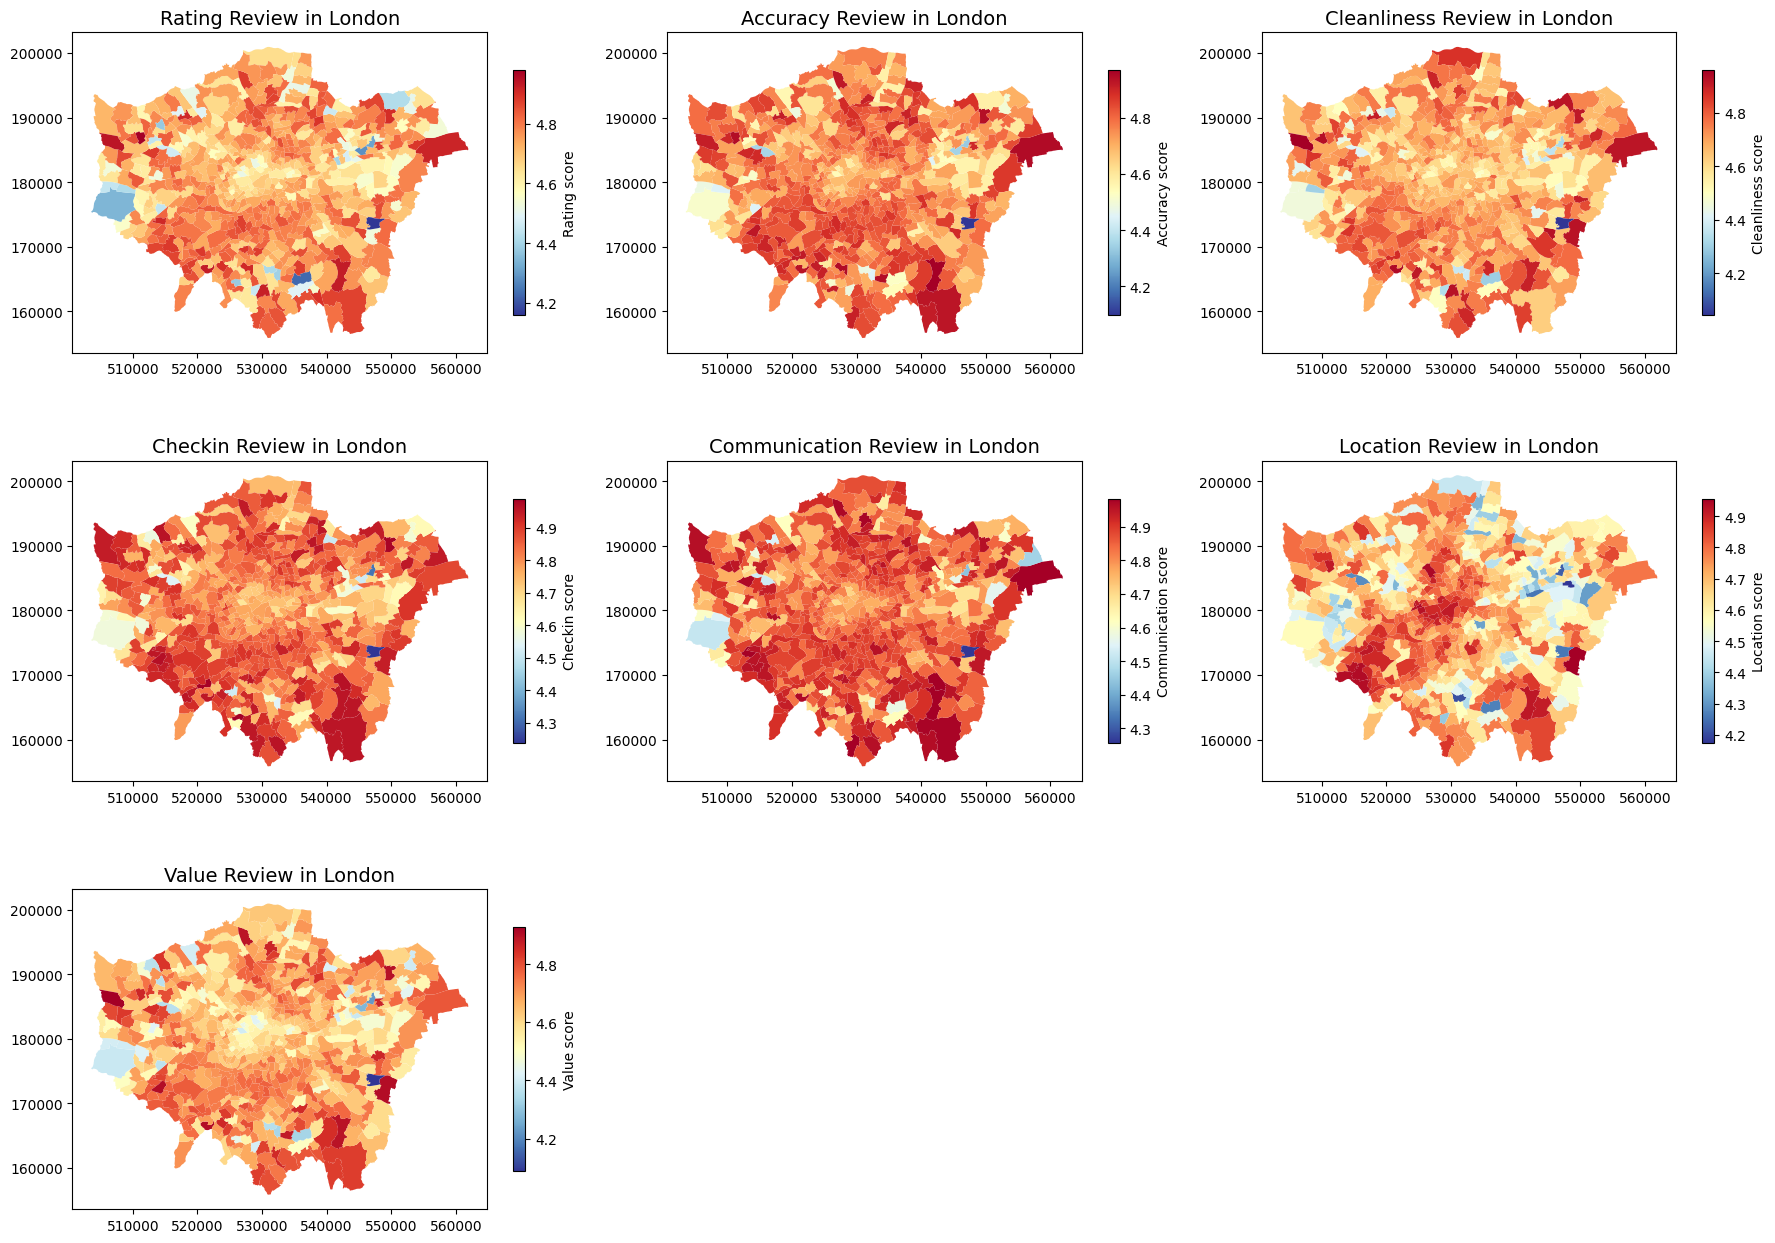

In [159]:
# List of 7 columns to plot
columns = ['Rating', 'Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']

# Create a 3x3 grid of subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 13))

# Flatten the array of axes for easier iteration
ax = ax.flatten()

# Plot each column in its own subplot
for i in range(len(columns)):
    London_Airbnb.plot(ax=ax[i], column=columns[i], cmap='RdYlBu_r', legend=True, linewidth=0.5,legend_kwds={'shrink': 0.6, 'label': columns[i] + ' score'})
    ax[i].set_title(columns[i].capitalize() + ' Review in London',fontsize=14)

# Hide the last two subplots (since we only have 7 plots)
for j in range(len(columns), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


##### 3.2 Price domain map in London

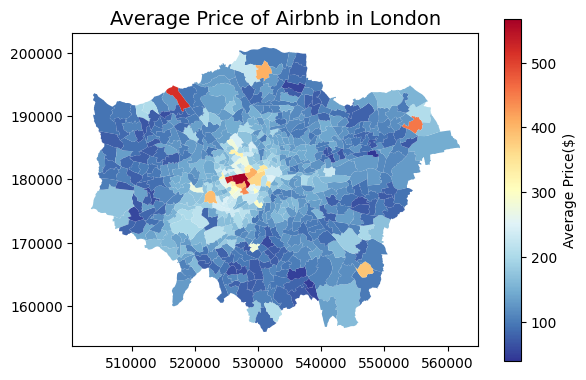

In [160]:
# Create a 3x3 grid of subplots
fig, ax = plt.subplots(figsize=(6, 6))


# Plot each column in its own subplot
London_Airbnb.plot(ax=ax, column='price', cmap='RdYlBu_r', legend=True, linewidth=0.5,legend_kwds={'shrink': 0.6,'label':'Average Price($)'})

ax.set_title('Average Price of Airbnb in London',fontsize=14)

plt.tight_layout()
plt.show()


#### 3.3 Explore the association between 7 review domains

#####3.3.1 Quantify the association between 7 domains using Spearman's rank correlation

In [161]:
# Calculate Spearman's rank correlation
Review_correlation =London_Airbnb[['Rating','Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']].corr(method = 'spearman')
Review_correlation

,Rating,Accuracy,Cleanliness,Checkin,Communication,Location,Value
Rating,1.000000,0.890731,0.812904,0.772816,0.838580,0.469820,0.875014
Accuracy,0.890731,1.000000,0.753360,0.763078,0.813873,0.509169,0.854472
Cleanliness,0.812904,0.753360,1.000000,0.680256,0.680837,0.449660,0.769302
Checkin,0.772816,0.763078,0.680256,1.000000,0.788590,0.426936,0.767215
Communication,0.838580,0.813873,0.680837,0.788590,1.000000,0.422025,0.789539
Location,0.469820,0.509169,0.449660,0.426936,0.422025,1.000000,0.392114
Value,0.875014,0.854472,0.769302,0.767215,0.789539,0.392114,1.000000


##### 3.3.2 Visualise the Spearman's rank correlation of the domains

Labels: Index(['Rating', 'Accuracy', 'Cleanliness', 'Checkin', 'Communication',
       'Location', 'Value'],
      dtype='object') Index(['Rating', 'Accuracy', 'Cleanliness', 'Checkin', 'Communication',
       'Location', 'Value'],
      dtype='object')
Labels with capital letters: ['Rating', 'Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value'] ['Rating', 'Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']


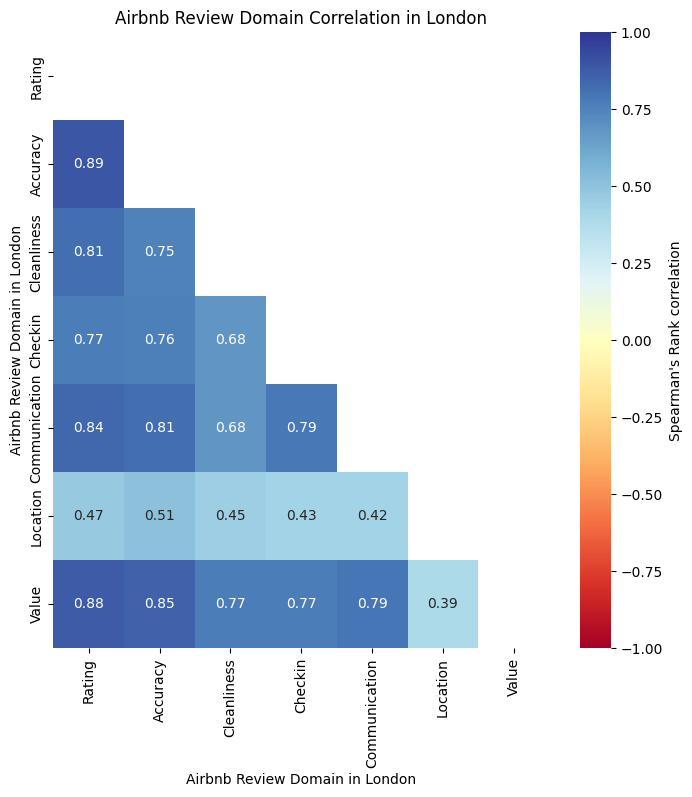

In [162]:
# Define plot size
fig,ax = plt.subplots(figsize=(8,8))

# Define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(Review_correlation))

# Define axis tick labels
# Get the index and the columns, replace the underscores with spaces and remove 'domain' from the name
x_axis_labels = Review_correlation.columns.str.replace('_',' ').str.replace('domain ','')
y_axis_labels = Review_correlation.index.str.replace('_',' ').str.replace('domain ','')

# Have a look at what the tick labels look like
print('Labels:',x_axis_labels ,y_axis_labels)

# Capitalize each tick label
# for each element in the list of x_axis_labels, capitalize it
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# Look at the new labels
print('Labels with capital letters:',x_axis_labels ,y_axis_labels)

# Plot a heatmap of the correlation dataframe
sns.heatmap(Review_correlation,
            # annotate so spearman's rank correlation values are displayed on the squares
            annot=True,
            # define colourmap
            cmap='RdYlBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom tick labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Airbnb Review Domain in London",
       ylabel="Airbnb Review Domain in London",
      title ='Airbnb Review Domain Correlation in London' );


# Part 4 Methodology and Visualization Result

## 4.1 K-Means clustering

####4.1.1 Identify the number of clusters using the elbow method and run the K-means model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

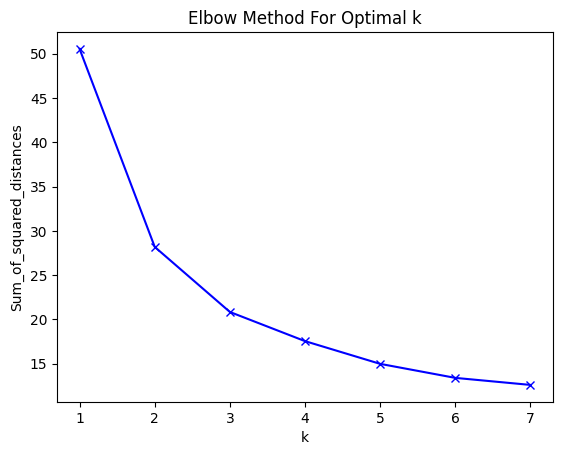

In [163]:
# Identify the number of clusters using the elbow method
# create an empty list to fill with values later
Sum_of_squared_distances = []

n_samples = Review_correlation.shape[0]

K = range(1, min(15, n_samples + 1))

for k in K:
    # create a k-means model with that number of clusters
    # set random state
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables of interest
    km = km.fit(London_Airbnb[['Rating', 'Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list we created earlier
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [164]:
# Run the model with 5 clusters
Km5 = cluster.KMeans(n_clusters=5,init="random", random_state=123)
Km5cls = Km5.fit(London_Airbnb[['Rating','Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']].values)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [165]:
# Each ward has been assigned a cluster in this array
Km5cls.labels_

array([2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1,
       2, 1, 2, 0, 2, 0, 1, 0, 3, 2, 2, 2, 1, 0, 1, 2, 1, 3, 2, 2, 3, 2,
       1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 4, 2, 2, 3, 2, 2,
       3, 2, 3, 1, 3, 3, 3, 4, 1, 3, 2, 2, 3, 2, 2, 1, 4, 0, 1, 1, 2, 3,
       2, 0, 2, 0, 1, 2, 3, 2, 1, 2, 1, 2, 1, 1, 2, 2, 4, 1, 2, 2, 2, 1,
       2, 0, 3, 2, 3, 1, 2, 1, 1, 4, 1, 1, 2, 3, 0, 3, 2, 0, 2, 0, 3, 3,
       3, 1, 1, 1, 1, 1, 2, 1, 4, 4, 0, 2, 2, 1, 2, 3, 1, 4, 1, 3, 1, 4,
       2, 2, 2, 1, 2, 1, 0, 4, 4, 0, 2, 2, 0, 1, 1, 3, 2, 3, 3, 2, 3, 3,
       2, 3, 3, 2, 3, 3, 2, 3, 2, 4, 2, 2, 3, 3, 1, 3, 2, 3, 2, 4, 2, 4,
       2, 1, 0, 3, 1, 1, 3, 2, 1, 2, 1, 0, 3, 2, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 2, 1, 1, 4, 1, 2, 2, 2, 4, 1, 2, 4, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 4, 4, 2, 2, 1, 4, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 4, 3, 2, 3, 1, 2, 4, 3, 2, 1, 1, 2, 3, 2,
       3, 3, 2, 3, 3, 1, 3, 4, 1, 3, 2, 1, 1, 1, 2,

In [166]:
# Create a new column with the cluster label
London_Airbnb['Cluster'] = Km5cls.labels_
London_Airbnb['Cluster'].head()

0    2
1    1
2    1
3    2
4    1
Name: Cluster, dtype: int32

####4.1.2 Explore the clustering results

##### Visualise statistical characteristics of each cluster by median domain values

In [167]:
# Use groupby to get the median value of each Airbnb domain by cluster
clusters_median = London_Airbnb.groupby('Cluster')[['Rating','Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']].median().reset_index()

In [168]:
clusters_median

,Cluster,Rating,Accuracy,Cleanliness,Checkin,Communication,Location,Value
0,0,4.454815,4.515053,4.456620,4.593750,4.616842,4.420848,4.403521
1,1,4.821349,4.845642,4.770955,4.888375,4.910000,4.802641,4.758650
2,2,4.745236,4.776112,4.699533,4.838617,4.862203,4.660401,4.686317
3,3,4.634389,4.663139,4.590064,4.748042,4.782362,4.554937,4.577434
4,4,4.683346,4.734693,4.645673,4.781590,4.809964,4.800159,4.605958


In [169]:
# Transform the data from a 'wide' format to a 'long' format to plot
Clusters_median_plot = pd.melt(clusters_median,id_vars = 'Cluster',value_vars = ['Rating','Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value'])

In [170]:
# Check the data
Clusters_median_plot.head()

,Cluster,variable,value
0,0,Rating,4.454815
1,1,Rating,4.821349
2,2,Rating,4.745236
3,3,Rating,4.634389
4,4,Rating,4.683346


In [171]:
# Rename columns
Clusters_median_plot.columns = ['Cluster','Review Domain','Median value']

In [172]:
# Rename the data
Clusters_median_plot.head()

,Cluster,Review Domain,Median value
0,0,Rating,4.454815
1,1,Rating,4.821349
2,2,Rating,4.745236
3,3,Rating,4.634389
4,4,Rating,4.683346


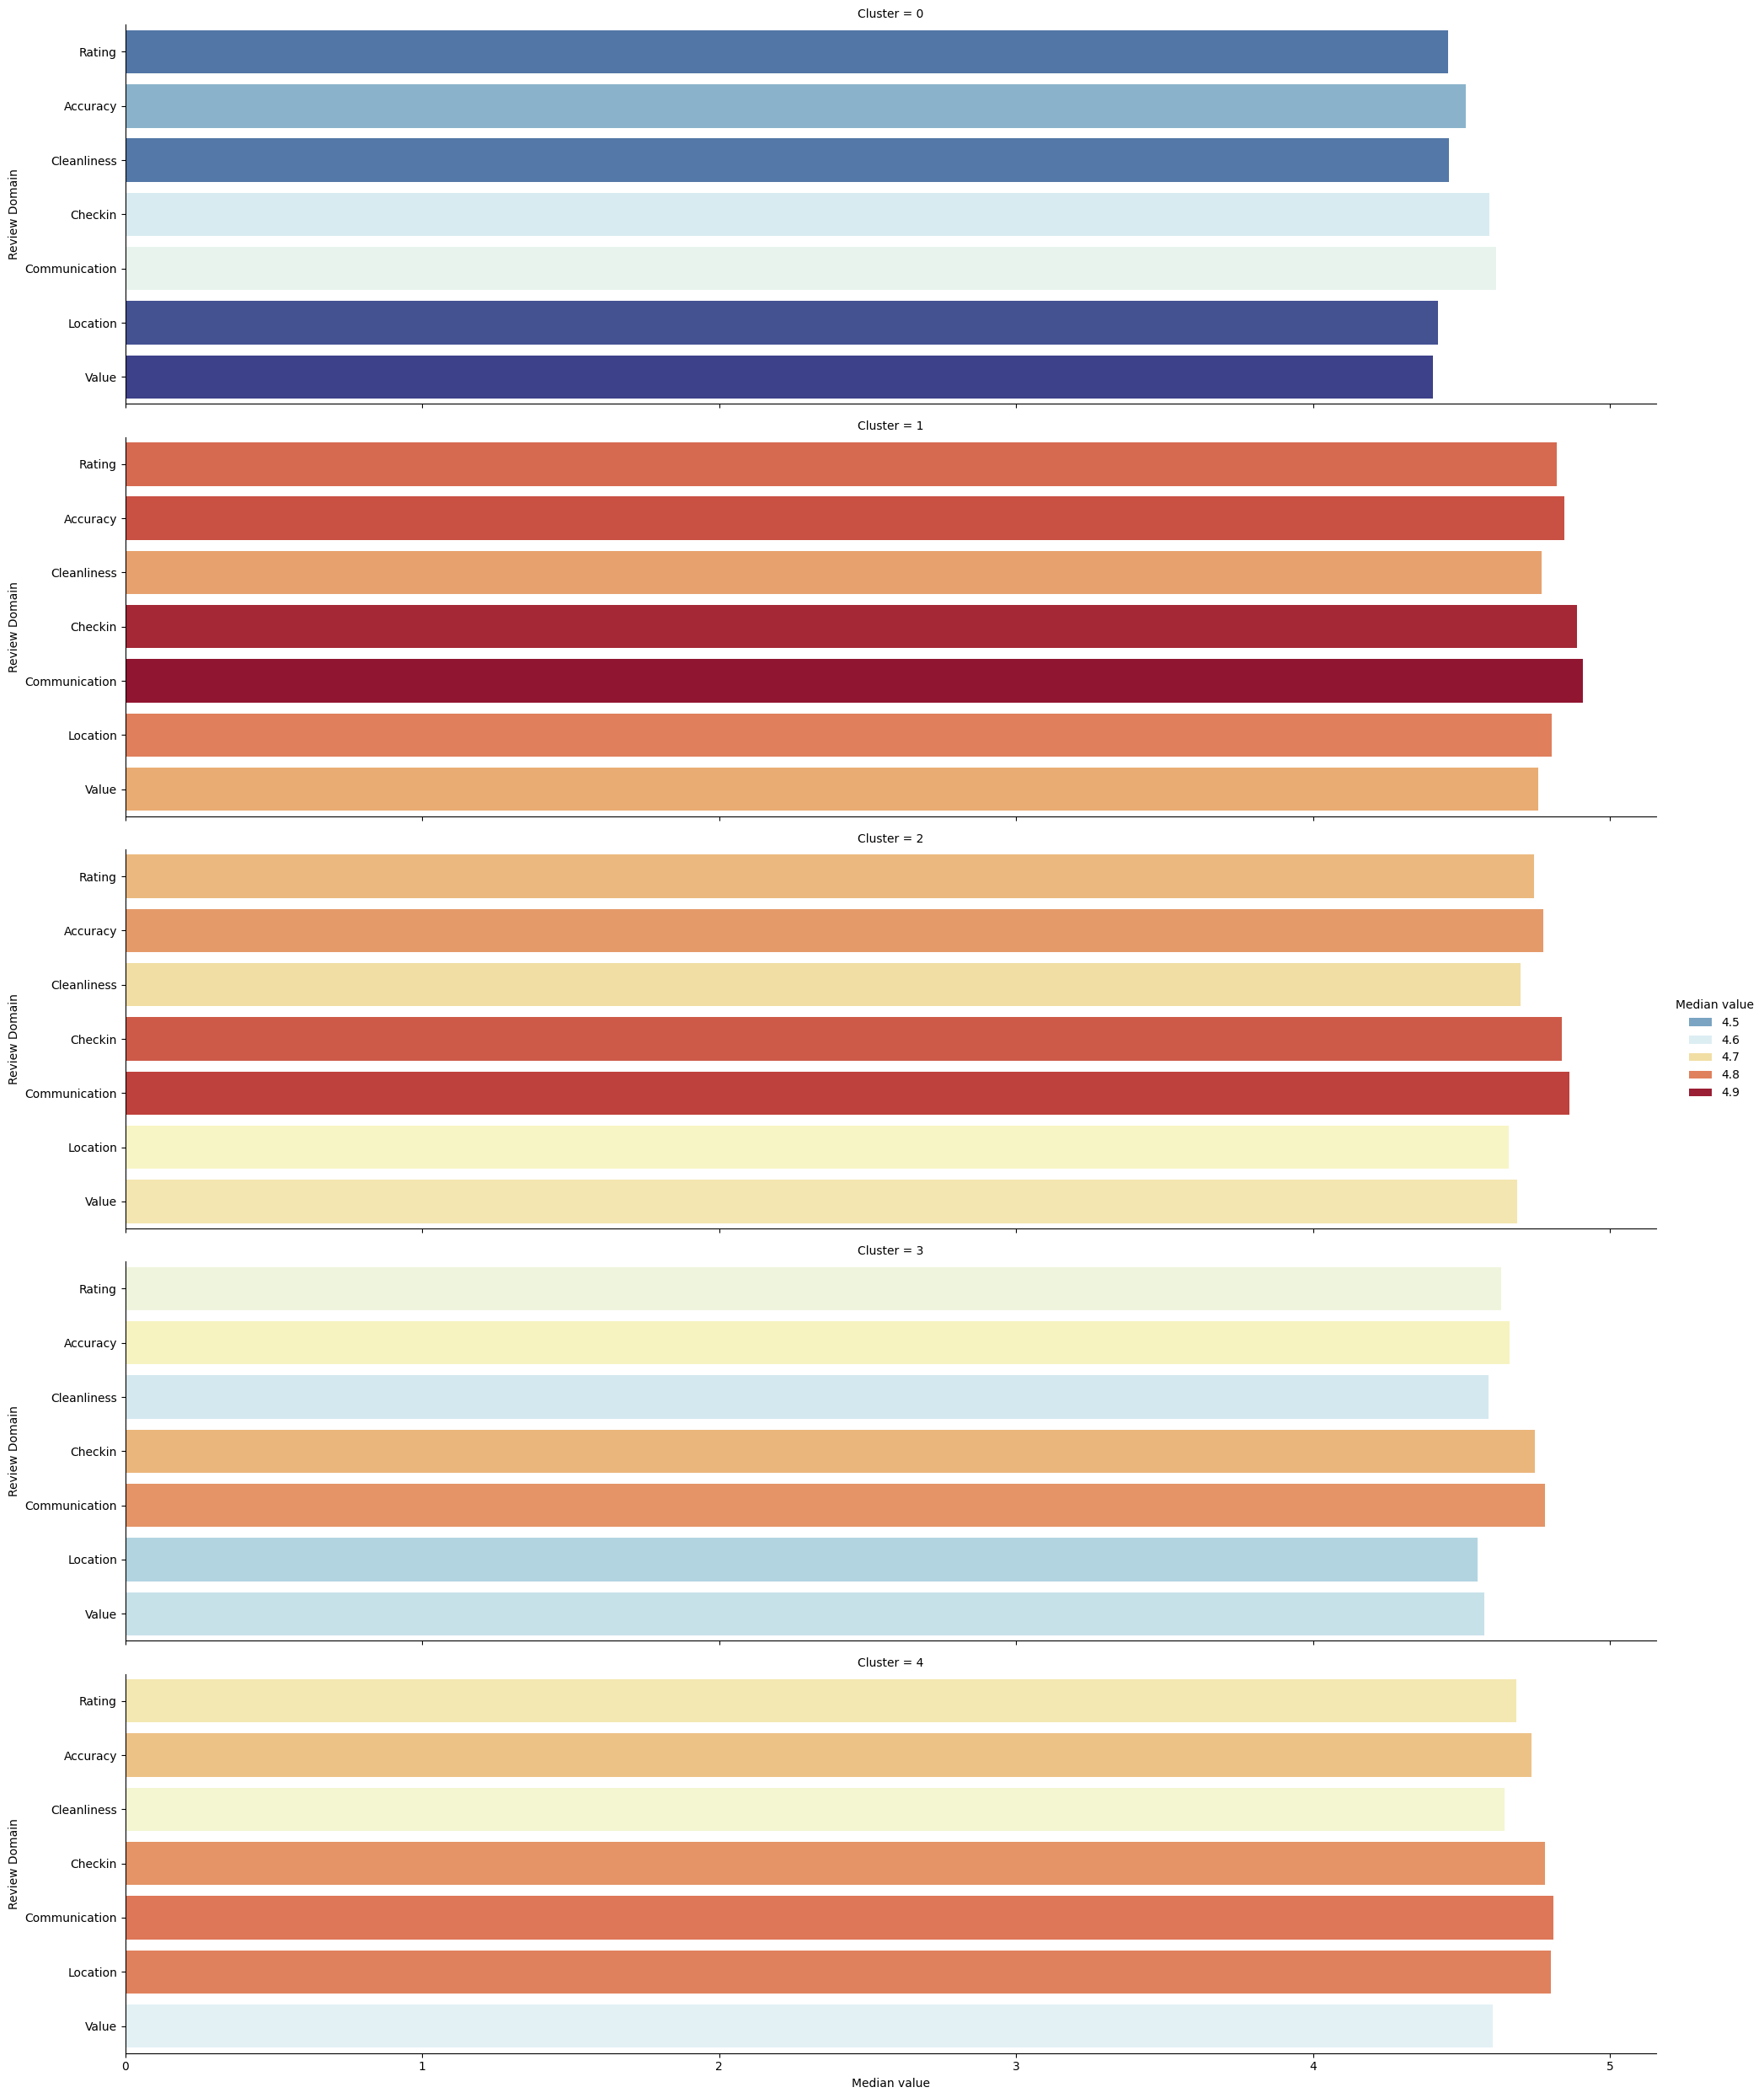

In [173]:
# Plot a faceted bar chart, where each row is a different cluster
sns.catplot(Clusters_median_plot,
            row='Cluster',
            y='Review Domain',
            x='Median value',
            kind='bar',
            aspect=4,
            hue='Median value',
            palette='RdYlBu_r')
plt.savefig('cluster_domains_overview.png')

##### Name clusters and get spatial visualisation


In [174]:
# Create empty column
London_Airbnb['Cluster_description']=""
London_Airbnb['Sort']=""

In [175]:
# Add cluster descriptions
London_Airbnb.loc[London_Airbnb['Cluster']==0,'Cluster_description']='Upscale hotels offering excellent checkin and communication services'
London_Airbnb.loc[London_Airbnb['Cluster']==1,'Cluster_description']='Comfortable lodgings with good communication but slightly higher prices'
London_Airbnb.loc[London_Airbnb['Cluster']==2,'Cluster_description']='Poor options with cleanliness concerns, poor locations, and minimal value'
London_Airbnb.loc[London_Airbnb['Cluster']==3,'Cluster_description']='Fair accommodations with less-than-ideal locations, and limited value proposition'
London_Airbnb.loc[London_Airbnb['Cluster']==4,'Cluster_description']='Luxurious accommodations with top-notch checkin and communication service'

In [176]:
# Add cluster descriptions
London_Airbnb.loc[London_Airbnb['Cluster']==0,'Sort']= 2
London_Airbnb.loc[London_Airbnb['Cluster']==1,'Sort']= 3
London_Airbnb.loc[London_Airbnb['Cluster']==2,'Sort']= 5
London_Airbnb.loc[London_Airbnb['Cluster']==3,'Sort']= 4
London_Airbnb.loc[London_Airbnb['Cluster']==4,'Sort']= 1

In [177]:
London_Airbnb.head()

,NAME,GSS_CODE,DISTRICT,HECTARES,geometry,Rating,Accuracy,Cleanliness,Checkin,Communication,Location,Value,price,Cluster,Cluster_description,Sort
0,Chessington South,E05000405,Kingston upon Thames,755.173,"POLYGON ((516401.596 160201.802, 516407.302 16...",4.790000,4.759286,4.682857,4.785714,4.911429,4.695714,4.712143,129.470588,2,"Poor options with cleanliness concerns, poor l...",5
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,259.464,"POLYGON ((519552.998 164295.600, 519508.096 16...",4.852727,4.859091,4.770909,4.920000,4.937273,4.646364,4.760000,111.538462,1,Comfortable lodgings with good communication b...,3
2,Berrylands,E05000401,Kingston upon Thames,145.390,"POLYGON ((518107.499 167303.399, 518114.301 16...",4.875758,4.896364,4.856364,4.946061,4.923636,4.822727,4.789394,128.192308,1,Comfortable lodgings with good communication b...,3
3,Alexandra,E05000400,Kingston upon Thames,268.506,"POLYGON ((520336.700 165105.498, 520332.198 16...",4.749412,4.789412,4.791176,4.818235,4.827059,4.637647,4.567647,160.200000,2,"Poor options with cleanliness concerns, poor l...",5
4,Beverley,E05000402,Kingston upon Thames,187.821,"POLYGON ((521201.203 169275.505, 521204.303 16...",4.842857,4.920714,4.877143,4.985000,4.913571,4.808214,4.774643,96.000000,1,Comfortable lodgings with good communication b...,3


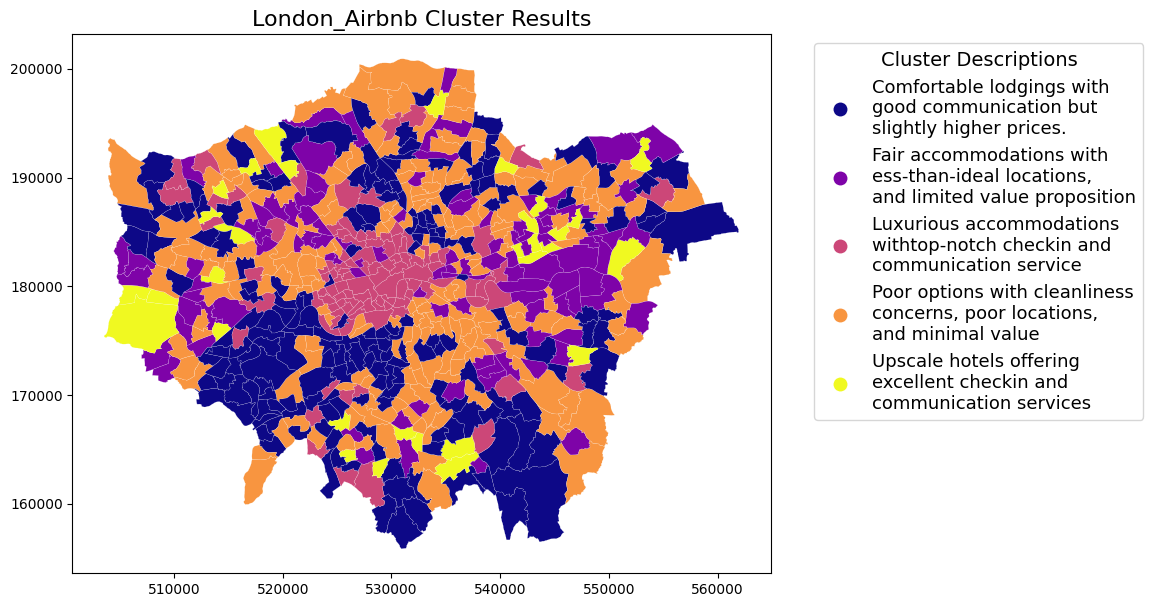

In [178]:
# Define camp
my_cmap=['#FFB000','#785EF0','#DC267F','#FE6100','#648FFF']

# Modify the legend labels to insert line breaks
legend_labels = {
    'Comfortable lodgings with\ngood communication but\nslightly higher prices.': '3',
    'Fair accommodations with\ness-than-ideal locations,\nand limited value proposition': '4',
    'Luxurious accommodations\nwithtop-notch checkin and\ncommunication service': '1',
    'Poor options with cleanliness\nconcerns, poor locations,\nand minimal value': '5',
    'Upscale hotels offering\nexcellent checkin and\ncommunication services': '2'
}


 # Create a spatial visualisation map
f, ax = plt.subplots(1, figsize=(10, 7))
London_Airbnb.plot(column='Cluster_description', categorical=True, legend=True, \
           linewidth=0.1, edgecolor='white', ax=ax, cmap='plasma',
           legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left', 'title': 'Cluster Descriptions', 'labels': legend_labels,'title_fontsize':14,'fontsize':13})

ax.set_title("London_Airbnb Cluster Results", fontsize=16)

plt.show()


# Spatial visualisation result

In [179]:
Final_map = London_Airbnb.sort_values('Cluster_description').explore('Cluster_description', categorical =True, cmap='plasma')

In [180]:
Final_map

Output hidden; open in https://colab.research.google.com to view.

## 4.2 Ordinary Least Squares（OLS) and correlation

# Nonspatial visualisation result

In [181]:
# Define independent variables (predictors) and dependent variable (response)
X = London_Airbnb[['Rating','Accuracy', 'Cleanliness', 'Checkin', 'Communication', 'Location', 'Value']]
y = London_Airbnb['price']

# Add an intercept
X = sm.add_constant(X)

# Perform regression analysis
# Linear case
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     53.77
Date:                Thu, 23 May 2024   Prob (F-statistic):           4.88e-60
Time:                        23:13:00   Log-Likelihood:                -3392.0
No. Observations:                 633   AIC:                             6800.
Df Residuals:                     625   BIC:                             6836.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            72.0402    124.525      0.579

In [182]:
# Relationship between score and price
corr = London_Airbnb[['Sort', 'price']].corr(method = 'spearman')

In [183]:
corr

,Sort,price
Sort,1.000000,-0.337506
price,-0.337506,1.000000


# Markdown
**Part 1 Import packages**

The packages selected are Pandas, Numpy, Geopandas, Matplotlib.pyplot, Seaborn, sklearn, Statsmodels and Mapclassify.


**Part 2 Data cleaning and preparation.**

The non-spatial dataset is a set of Airbnb listings in the London area up to 19 March 2024, where different aspects such as price, customer feedback, etc. are included in this listing. The spatial dataset is the Ward spatial data for the London area for the year 2018. The two datasets are preprocessed and linked.

2.1 and 2.2 read the spatial and non-spatial datasets respectively to see the basic information and descriptive statistics of the dataset, removing missing values, duplicates, and other problems present in the original data (Tukey et al., 1977).

In the London spatial dataset, the data types are float 64, object and geometry with no missing values. The main application of ’geometry‘ in this study is to identify the London ward. The coordinate reference system is converted to the National Grid of the UK, which ensures that all subsequent spatial data manipulations are carried out using the National Grid of the UK. Finally, a visualisation via ‘explore’ to create an interactive map of the London wards.

In the non-spatial dataset, looking the first few rows of the Airbnb data via ‘head’. The data types are float64 and object, and there are missing values. To remove the missing values  from the dataset and the sign of ‘price’. The data type is float (Bo et al., 1988). Create point geometry using longitude and latitude. Convert Airbnb data into a GeoDataFrame which contains point geometry and add the point geometry that is created to the ’geometry‘ column. The coordinate system is converted to the UK National Grid.

(2.3)In the spatial dataset and non-spatial dataset are linked by ‘inner’. Get the dataset of Airbnb located inside London wards named ‘London_Airbnb’. 2.4 is to preprocess the data for ‘London_Airbnb’. Firstly, there are no missing values. Secondly, compute the mean of each of the 7 domains under study through ‘gruopby’. Thirdly, by ‘merge’ these 7 domains are stacked together by ‘left-join’. Rename the 7 domains and remove duplicate columns. (Bo et al., 1988). Finally, obtain the final dataset ‘London_Airbnb’.

**Part 3 Exploring the different review domains in London**

From Part 2 I want to study the 7 domains are 'rating', 'accuracy', 'cleanliness', 'check in', 'communication', 'location', 'value'. In Part 3, it is visualised separately and study the relationships between the domains. The reason why is to clearly see the spatial distribution of each domain in the London wards, providing help for K-means analysis and to understand pattern and trend in the data.

3.1 Create a 3-row, 3-column, figsize=(18, 13) to display the 7 domains. 'ax = ax.flatten() 'is to flatten the array of subplots for easy iteration. Use the loop ‘for i in range(len(columns))’ to plot the appropriate columns in each subfigure and set the legend and title. ‘for j in range(len(columns), len(ax)) ’ is to hide redundant subplots as we only have 7 domains. The colour is ‘RdYlBu_r’, the legend is True, and set the fontsize to 14.

3.2 creat a price plot with figsize = (6,6) in the same way. 3.3 use the Spearman's rank correlation (Ali et al., 2022) to investigate the relationship between the 7 domains. Visualised out through ‘heatmap’. In the visualisation, figsize = (8,8) and colour is ‘RdYlBu’. Among them, the domains ‘Accuracy’ and ‘Rating’ are most correlated with each other at 0.89. The results show that the correlation between the domains are all more than 0 positively correlated, which indicates that there is a consistent trend between these domains.


**Part 4 Methodology and Visualization**.

The methods are K-means and OLS(Ordinary Least Squares).

**spatial visualisation result**

4.1 In the process of K-means (Sinaga  et al., 2020):

***First***, Identify the number of clusters using the elbow method:

1.Initialise the list and range. Create an empty lis‘Sum_of_squared_distances’ to store the total sum of squares (SSD) for each k value. Set the range of k values, K, from 1 to the minimum of the data samples and the minimum of 15.

2.Loop through the calculation of the SSD for each k-value: for each k-value, create and train a K-means model. Calculate and store the total sum of squares (SSD) for each model as ‘km.inertia_’.

3.The optimal k value could be determined by observation of the position of the ‘elbow’ in the plot. The optimal k value could be determined by observation of the position of the ‘elbow’ in the plot. In combination with Spearman's rank correlation, the trend of the total sum of squares with the number of clusters is observed. To find a balance that makes the clustering result both compact and not complex, here I choose k=5.

***Secondly,***  Run a K-means model with 5 clusters:

1.Create the example data frame ‘London_Airbnb’ which contains the scoring domains.

2.After that create a K-means model with 5 clusters, with ‘random’ initialisation and random state is ‘123’.

3.The model is then trained using the selected scoring domains.

***Thirdly***, Data allocation to different clusters.

1.The data is assigned to different clusters using the K-means clustering model, each London ward is assigned to a cluster and these cluster labels are stored in the 'Km5cls.labels_ '.

2.Add the cluster labels to the data frame.

***Fourthly***, Calculate the median value of each scoring domain.

1.The median value of each scoring domain in each clustered cluster is calculated using ‘groupby’. The median is a stable statistic that effectively reflects the central trends in the data (Durduran, 2015).

2.The data is converted from ‘wide format’ to ‘long format’ using ‘pd.melt’ and then renamed to the dataset.

3.Present the cluster results in a faceted bar chart, colour is ‘RdYlBu_r’.

***Fifthly***, Create Cluster Description and Sort.

Based on the cluster results, two new columns 'Sort' and 'Description' are created and put together. As sort of 1 means the service is the best and 5 is the worst. The description of each cluster is as follows:

Cluster 0 :  Uscale hotels offering excellent check in and communication services with a sort of 2.

Cluster 1：Comfortable lodgings with good communication but slightly higher prices，Sort is 3.

Cluster 2：Poor options with cleanliness concerns, poor locations, and minimal value，Sort is 5.

Cluster 3：Fair accommodations with less-than-ideal locations, and limited value proposition，Sort is 4.

Cluster 4：Luxurious accommodations with top-notch checkin and communication service，Sort is 1.

***Finally***, Creat static and interactive maps of cluster results.

Create a static map displaying spitial pattern and cluster with figsize=(10, 7) and colours : '#FFB000, #785EF0, #DC267F, #FE6100, #648FFF.' However, static map lacks interactivity and cannot explore the data in a dynamic way (Longley et al., 2005).

Other methods such as heatmap do not provide specific geographic location information, are less interactive, and users cannot look at the details of a single data point. Scatterplot may appear confused for a large database , it is difficult to recognise cluster.

An interactive map is created through 'explore' with the diagram name 'London_Airbnb Cluster results'. The colour is 'plasma'. This colour is friendly to everyone. The interactive map allow users to zoom, pan and click operations on the map to look at the corresponding sort and other domains such as ‘Accuracy’ and further explore the detail and pattern of the data. At the same time, the map can help identify geographic hot and cold spots and observe the differences between regions (Khan et al., 2011; Worboys et al., 2004).


**Non-spatial visualisation result**

4.2 It is obtained through Ordinary Least Squares (OLS) and correlation analysis (Carvalho et al., 2021).

***First***, the correlation analysis concluded that there is a negative relationship between price and sort, which indicates that the higher the sort, the lower the price.

***Secondly***, R-squared: 0.376. shows the goodness of fit of the model. The current R² value indicates that there are other domains that may affect price, but will not affect the results.Indicates accuracy of OLS results.

Significance Test (t):
'location':  t is 17.001 and a p-value of 0.000 indicate that Location has a significant positive 'Value': t is -5.694 and p-value is 0.000, indicating that 'Value' has a significant negative effect on price.







#Conclusion
To study the relationship between the price of Airbnb in London area and 7 domains, the study use the Spearman's rank correlation, K-means, Ordinary Least Squares（OLS） and correlation analysis. It concluded that the price of Airbnb in London area is related to these 7 domains. And the higher the sort with the lower price. Moreover, the price is most affected by the ‘location’ and ‘value’ domains. Besides this there are other domains that affect the price of Airbnb in London, such as ‘host response time’.

# References

[1] Ali Abd Al-Hameed, K. 2022. Spearman's correlation coefficient in statistical analysis.*International Journal of Nonlinear Analysis and Applications*.**13**(1), pp.3249-3255

[2] Bo, N., Little, R.J.A. and Rubin, D.B. 1988. Statistical Analysis with Missing Data. *Population (France)*. **43**(6), pp.1174-.

[3] Carvalho, C., Nechio, F. and Tristão, T. 2021. Taylor rule estimation by OLS. *Journal of monetary economics.* **124**, pp.140–154.

[4] Durduran, S.S. 2015. Automatic classification of high resolution land cover using a new data weighting procedure: The combination of k-means clustering algorithm and central tendency measures (KMC–CTM). *Applied soft computing*. **35**, pp.136–150.

[5] Khan, M. and Khan, S. S. 2011. Data and Information Visualization Methods, and Interactive Mechanisms: A Survey. *International Journal of Computer Applications*. **34**(1), pp. 1-14

[6] Longley, P. A., Goodchild, M. F., Maguire, D. J. and Rhind, D. W. 2005. Geographical Information Systems: Principles, Techniques, Management and Applications. *John Wiley & Sons.* **1**, pp. 42-.

[7] Sinaga, K. P. and Yang, M. S. 2020. Unsupervised K-means clustering algorithm. *IEEE access*. **8**, pp.80716-80727.

[8] Tukey, J. W. 1977. Exploratory data analysis. *Reading, MA: Addison-wesley*. **2**, pp.131-160.

[9] Worboys, M. F. and  Duckham, M. 2004. GIS: A Computing Perspective.*CRC Press*. **4**, pp.75-.

[10] GE0G5990M course materials

Data Source:

Airbnb:
https://insideairbnb.com/get-the-data  

London_Ward:
https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london



